In [1]:
# Definitions and functions
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
#sys.path.append(os.path.join(repos_folder, 'analysis-tools'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))
sys.path.append(os.path.join(repos_folder, 'tf_spectral'))

from swissknife.bci.core import expstruct as et

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp

from basic_viewing.structure import kwik_functions as kwkf
from basic_viewing.structure.core import h5_functions as kwdf

from swissknife.h5tools import h5tools as h5
from swissknife.streamtools import streams as st
from swissknife.streamtools import spectral as sp
from swissknife.streamtools import temporal as tp

from tf_spectral.core import tensorops

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

def list_sum(a_list):
    s = a_list.pop(-1)
    for new_s in a_list:
        s+=new_s
    return s

print 'All modules loaded'

Computer: passaro
All modules loaded


In [2]:
def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

def filter_rms(x, filter_pars):
    return st.rms(sp.apply_butter_bandpass(x, filter_pars))

def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []

    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                       s_f,
                                       dtype=np.float),
                             np.array(chan_list),
                             [start, start + span])
        frames.append(one_frame)
    return frames

import scipy


def spectrogram(x, s_f, n_perseg = None, n_overlap=None, cut_off=90, sigma=0.3):
    f, t, s = scipy.signal.spectrogram(x, fs=s_f, window=sg.gaussian(n_perseg, sigma), 
                         nperseg=n_perseg, 
                         noverlap=n_overlap, 
                         nfft=None, 
                         detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')

    s[s<np.max(s)/np.exp(cut_off/10)]=np.max(s)/np.exp(cut_off/10)
    return f, t, s


def normalize(u, axis=0):
    # normalize to (0-1) along axis
    # (axis=0 to normalize every col to its max value, axis=0 to normalize every row to its max value)
    u_max = np.repeat(np.amax(u, axis=axis, keepdims=True), u.shape[axis], axis=axis)
    # print(u_max.shape)
    u_min = np.repeat(np.amin(u, axis=axis, keepdims=True), u.shape[axis], axis=axis)

    u_range = u_max - u_min
    u_range[u_range==0] = 1 # prevent nans, if range is zero set the value to 1.
    return (u - u_min)/u_range


In [3]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
stim_sess = '001'

spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'cut_off': 0.000065 }

filter_band = [300, 7500]


    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = exp_par['search_motiff']['motiff_patterns']
print pattern_names

{'motiff_1': 'motiff_1.wav'}


550.4
fcut_plot 10000


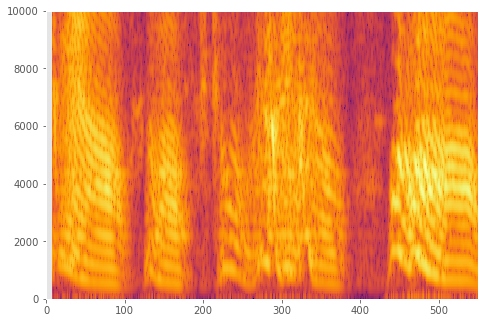

In [4]:
reload(sp)
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
ax = spec_obj.plot()

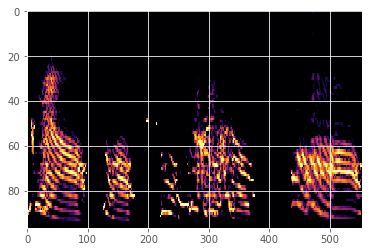

In [10]:

win_s = .005
win_samples = 96*2
step_s = .001
f_cut = 15000

#n_perseg = int(s_f * win_s)
n_perseg = win_samples

s_f = 30000
#n_overlap = int(s_f * (win_s - step_s))
n_overlap = win_samples - int(s_f*step_s)


f, t, s = spectrogram(m_chunk.data[:,0], s_f, n_perseg=n_perseg, n_overlap=n_overlap, cut_off=80, sigma=40)

plt.imshow(normalize(np.log(s))[::-1], aspect='auto', cmap='inferno')

In [11]:
f

array([     0.  ,    156.25,    312.5 ,    468.75,    625.  ,    781.25,
          937.5 ,   1093.75,   1250.  ,   1406.25,   1562.5 ,   1718.75,
         1875.  ,   2031.25,   2187.5 ,   2343.75,   2500.  ,   2656.25,
         2812.5 ,   2968.75,   3125.  ,   3281.25,   3437.5 ,   3593.75,
         3750.  ,   3906.25,   4062.5 ,   4218.75,   4375.  ,   4531.25,
         4687.5 ,   4843.75,   5000.  ,   5156.25,   5312.5 ,   5468.75,
         5625.  ,   5781.25,   5937.5 ,   6093.75,   6250.  ,   6406.25,
         6562.5 ,   6718.75,   6875.  ,   7031.25,   7187.5 ,   7343.75,
         7500.  ,   7656.25,   7812.5 ,   7968.75,   8125.  ,   8281.25,
         8437.5 ,   8593.75,   8750.  ,   8906.25,   9062.5 ,   9218.75,
         9375.  ,   9531.25,   9687.5 ,   9843.75,  10000.  ,  10156.25,
        10312.5 ,  10468.75,  10625.  ,  10781.25,  10937.5 ,  11093.75,
        11250.  ,  11406.25,  11562.5 ,  11718.75,  11875.  ,  12031.25,
        12187.5 ,  12343.75,  12500.  ,  12656.25, 

In [15]:
np.log10(pow(10, 5))

5.0

In [16]:
np.log(100)/np.log(10)

2.0

In [17]:
1./np.log(10)

0.43429448190325176

In [21]:
np.max(np.log(s)/np.log(10))

5.8490067

In [25]:
np.max(s)

13.467835

In [7]:
reload(tsp)
sigma = 60
n_perseg = 512
s = tsp.spectrogram_tf(m_chunk.data[:,0], fft_size=n_perseg, step_size=30, log=True,
                            db_cut=45, window=sg.gaussian(n_perseg, sigma))

cut_off = 75
#s[s<np.max(s)/np.exp(cut_off/10)]=np.max(s)/np.exp(cut_off/10)

#s[s<np.max(s)*0.65]=0
plt.imshow((s.T)[::-1], aspect='auto', cmap='inferno')
np.any(np.isnan(s))

NameError: name 'tsp' is not defined

In [39]:
np.any(s<0)

False

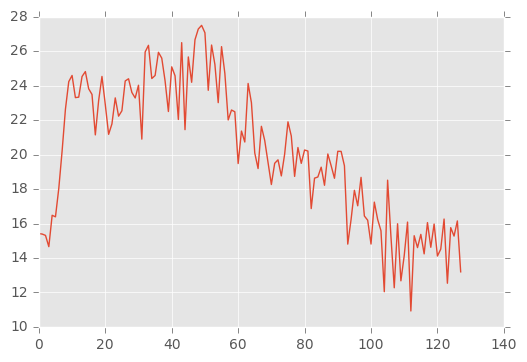

In [56]:
plt.plot((s)[290])

(129, 551)


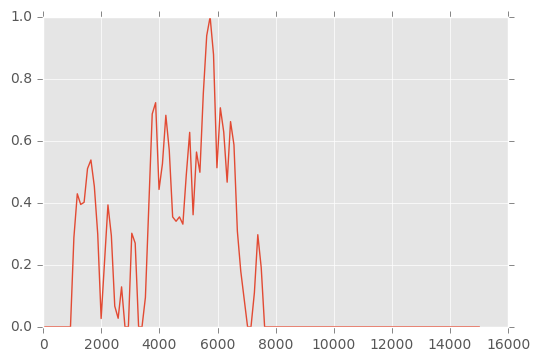

In [118]:
plt.plot(f, normalize(np.log(s))[:,290])

In [13]:
# collect all the bout streams for a bird, sess
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())



2017-04-26 19:12:19,506 root         INFO     Collecting 38 frames...
2017-04-26 19:12:19,508 root         INFO     Frame 0 ...
2017-04-26 19:12:19,792 root         INFO     Frame 10 ...
2017-04-26 19:12:19,979 root         INFO     Frame 20 ...
2017-04-26 19:12:20,153 root         INFO     Frame 30 ...
2017-04-26 19:12:21,922 root         INFO     Collecting 66 frames...
2017-04-26 19:12:21,924 root         INFO     Frame 0 ...
2017-04-26 19:12:22,159 root         INFO     Frame 10 ...
2017-04-26 19:12:22,380 root         INFO     Frame 20 ...
2017-04-26 19:12:22,512 root         INFO     Frame 30 ...
2017-04-26 19:12:22,848 root         INFO     Frame 40 ...
2017-04-26 19:12:23,111 root         INFO     Frame 50 ...
2017-04-26 19:12:23,227 root         INFO     Frame 60 ...
2017-04-26 19:12:25,099 root         INFO     Collecting 97 frames...
2017-04-26 19:12:25,101 root         INFO     Frame 0 ...
2017-04-26 19:12:26,008 root         INFO     Frame 10 ...
2017-04-26 19:12:26,995 ro

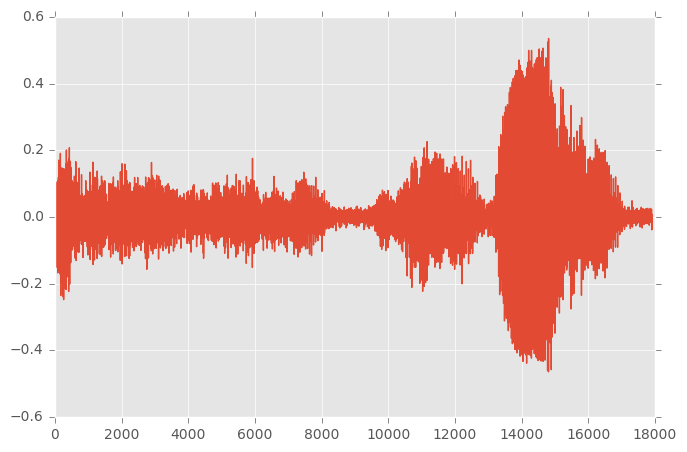

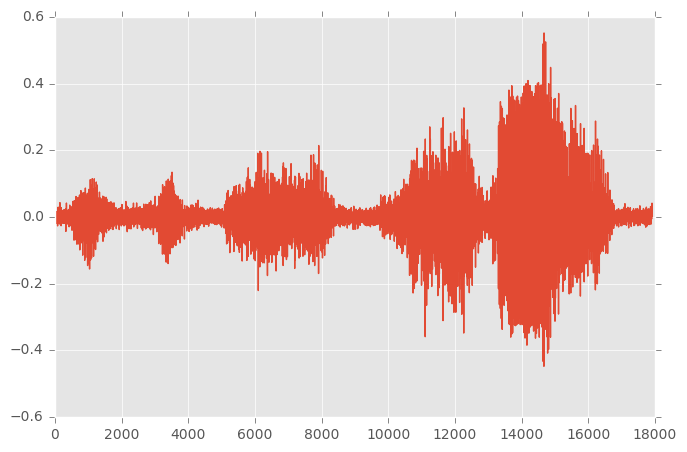

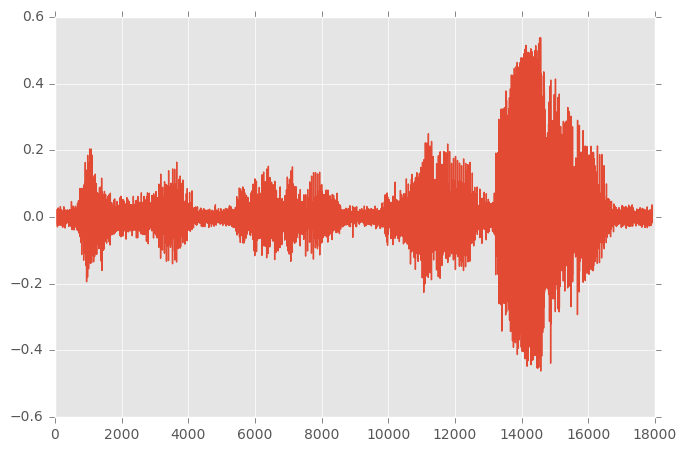

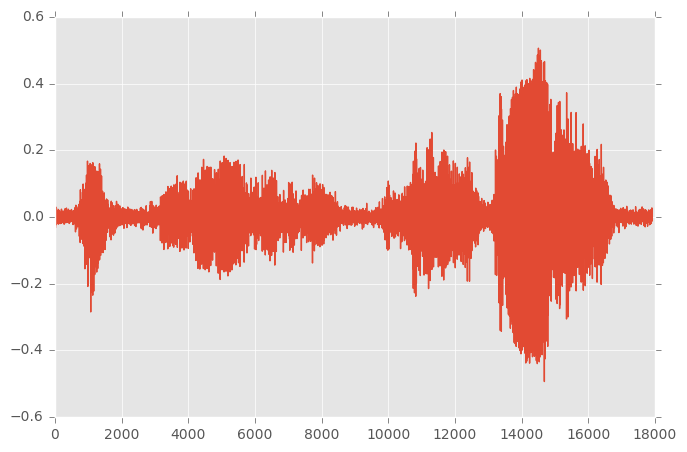

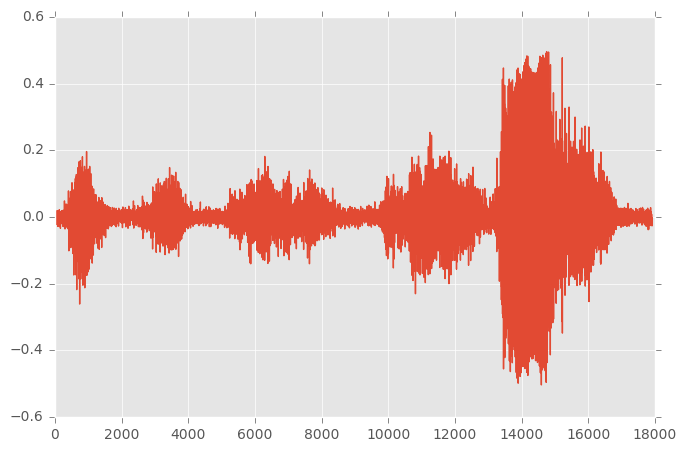

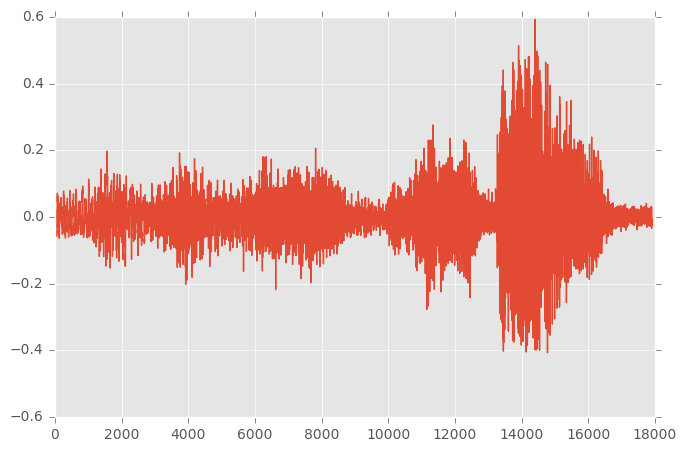

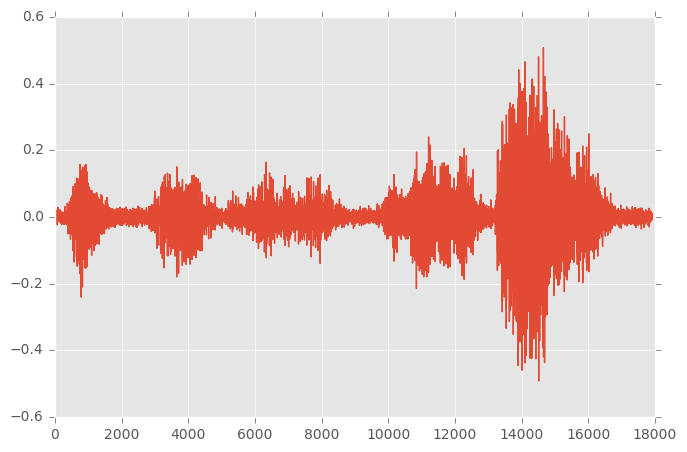

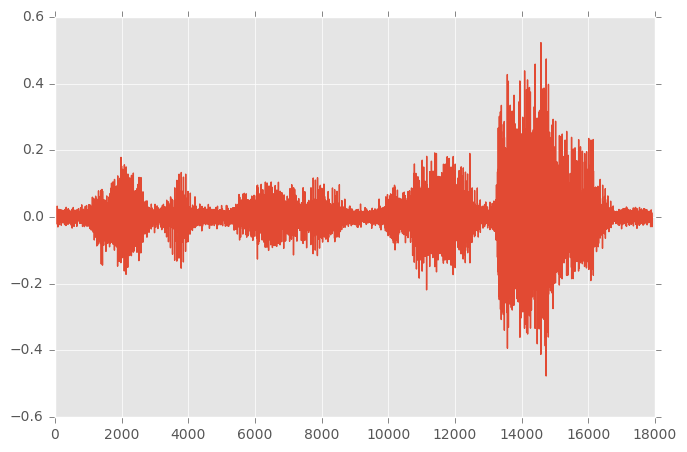

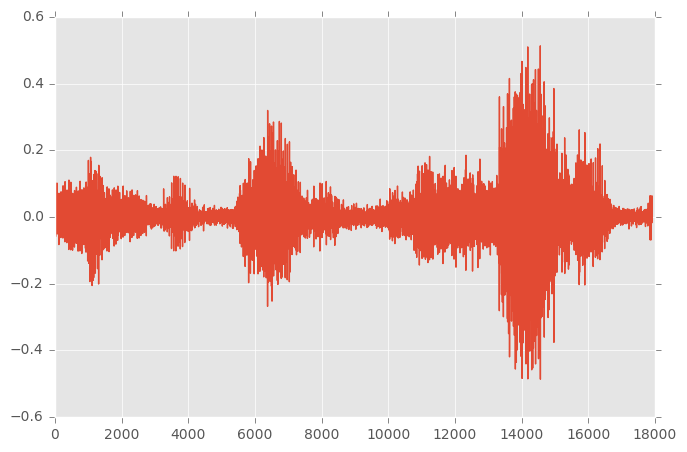

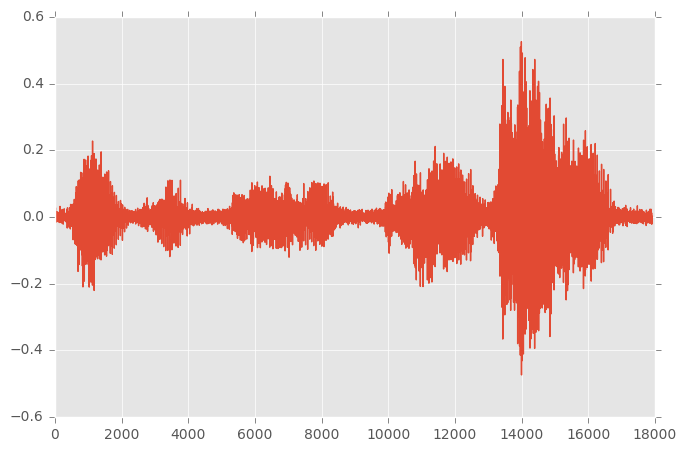

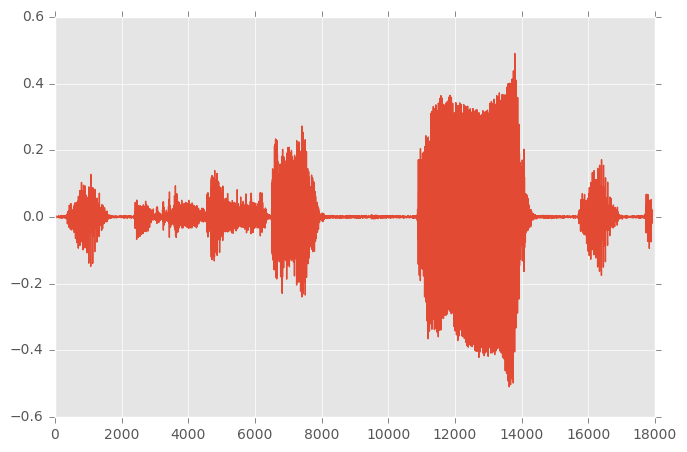

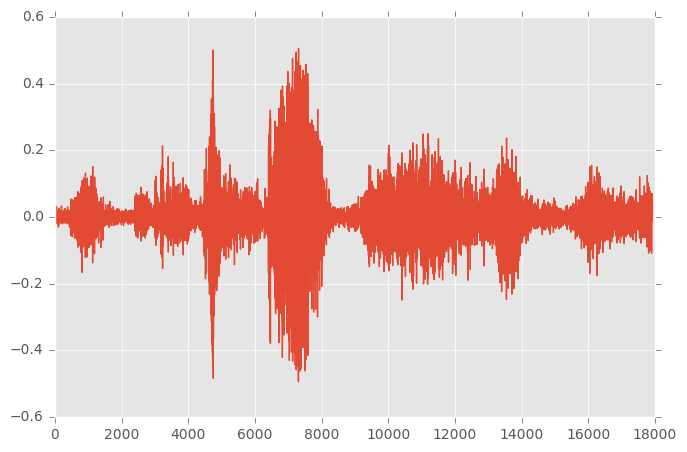

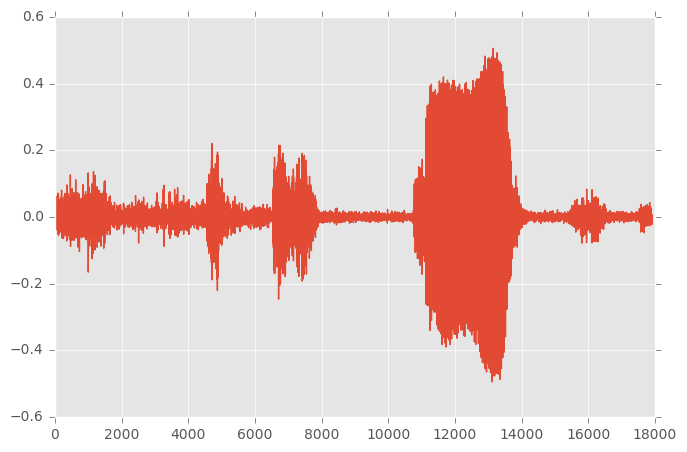

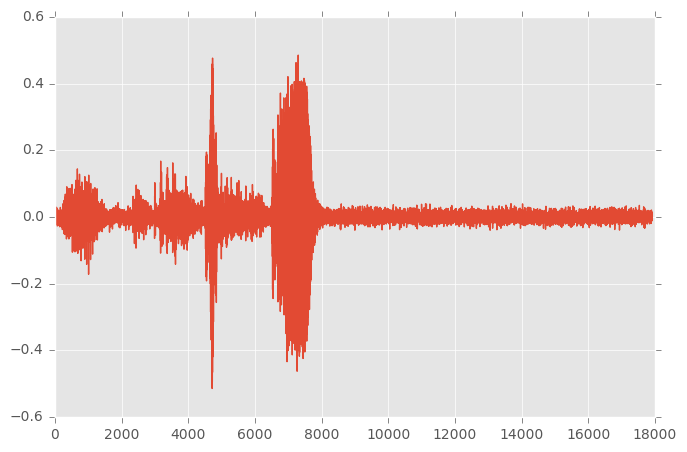

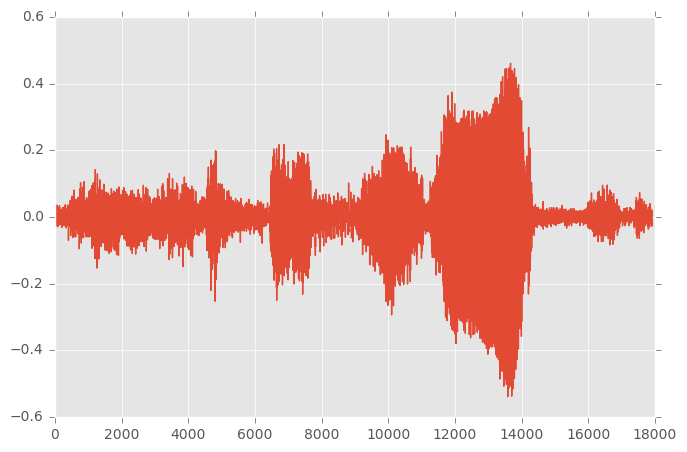

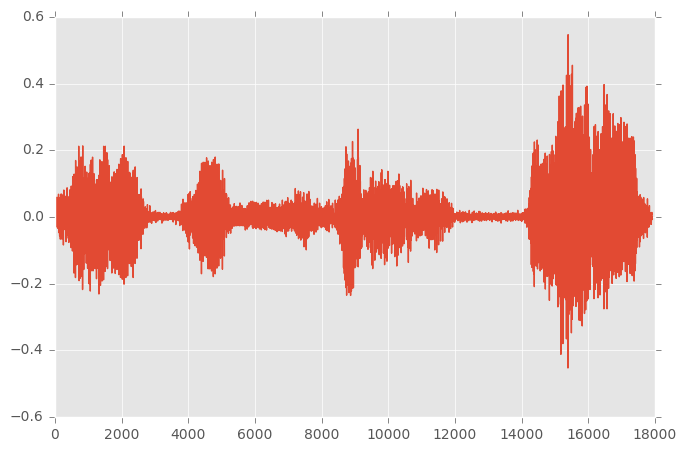

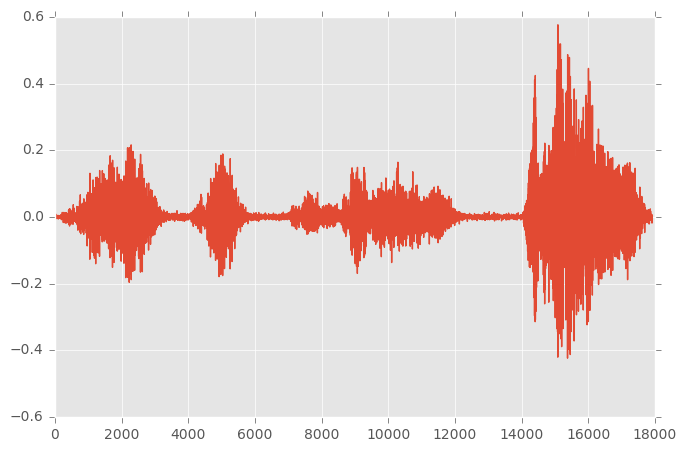

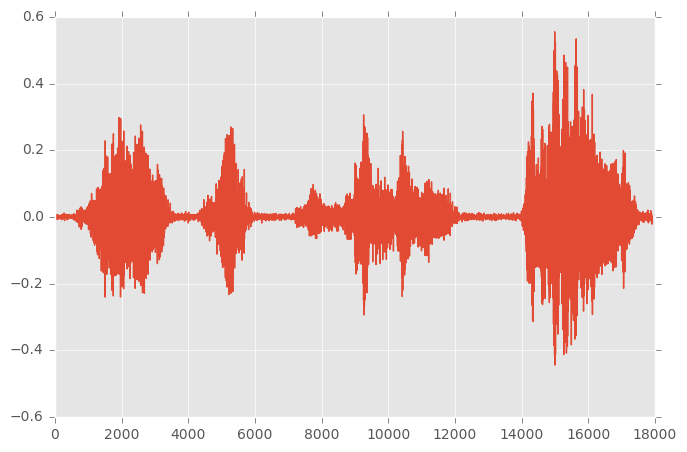

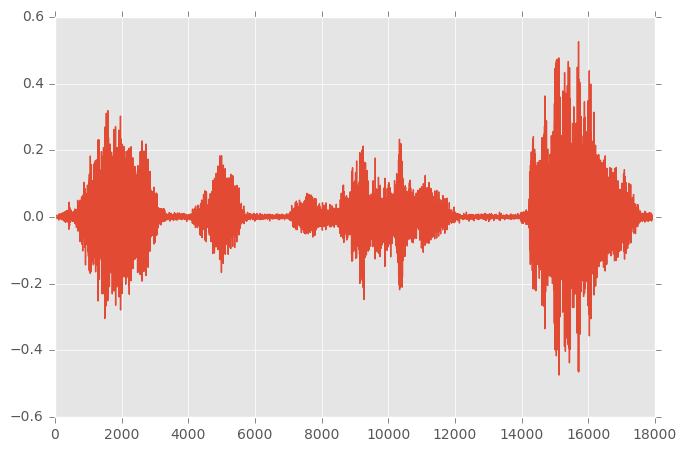

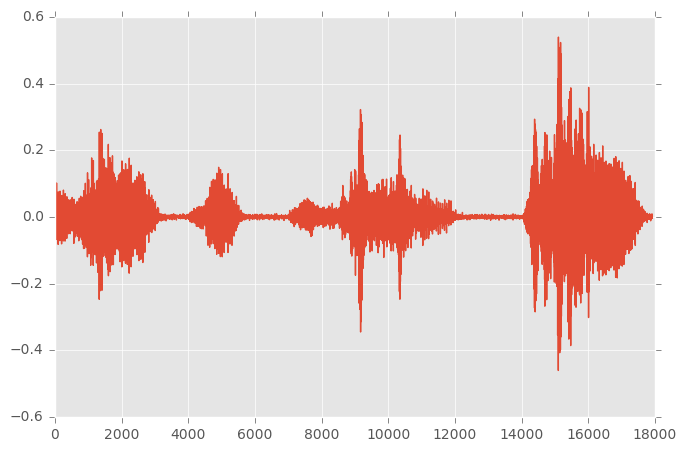

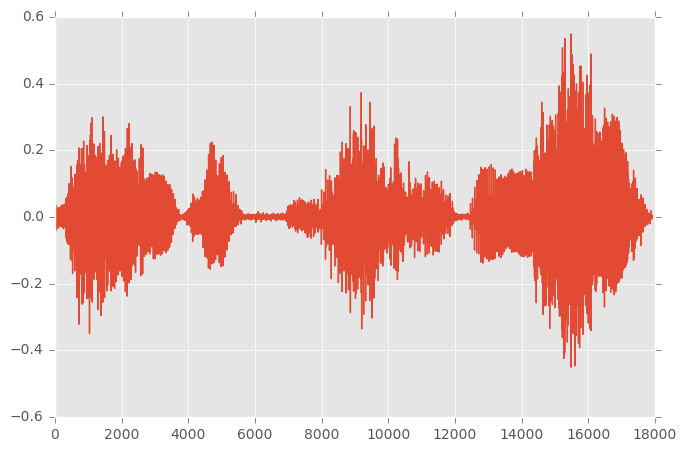

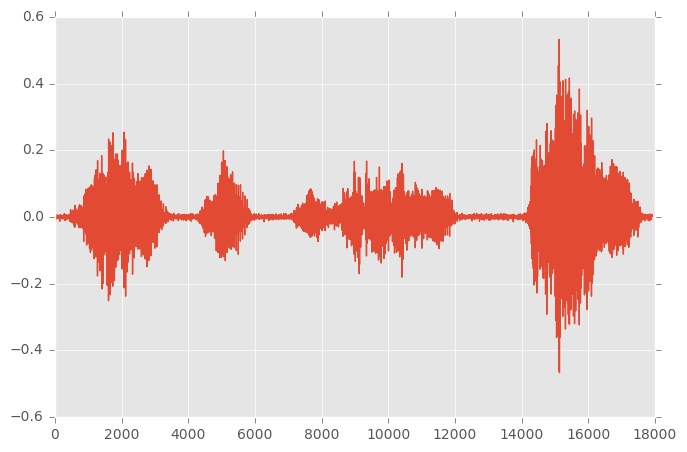

In [123]:
def make_data_frame(bird, sess):
    
    exp_par = et.get_parameters(bird, sess)
    fn = et.file_names(bird, sess)
    song_file_path = et.file_path(fn, 'ss', 'sng')
    song_file = h5py.File(song_file_path, 'r')

    pattern_names = exp_par['search_motiff']['motiff_patterns']
    
    m = evt.Song(m_name, song_file)
    kwd_file = et.open_kwd(bird, sess)
    starts = m.get_start()
    recs = m.get_rec()

    m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

    mic_chan = np.array([exp_par['channel_config']['mic']])

    win_samples = 128*2
    step_s = .001
    f_cut = 15000

    #n_perseg = int(s_f * win_s)
    n_perseg = win_samples
    
    n_overlap = win_samples - int(s_f*step_s)

    before = 150
    after = 1000

    with et.open_kwd(bird, sess) as kwd_file:
        collected_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                                    s_f, 
                                    kwd_file, recs, mic_chan)

    spectra = []
    for one_frame in collected_frames:
        one_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)
        f, t, s = spectrogram(one_frame.data.flatten(), s_f, n_perseg=n_perseg, n_overlap=n_overlap, 
                              cut_off=80, sigma=40)
        spectra.append(normalize(np.log(s)))

    all_spectra = np.stack(spectra, axis=0)

    collected_frames[0].plot()

    syll_data = pd.DataFrame({
            'bird': [bird for i in np.ones_like(recs)],
            'sess': [sess for i in np.ones_like(recs)],
            'rec': recs.tolist(),
            'start': starts.tolist(),
            'spectral': all_spectra.tolist()
        })

    syll_data.to_pickle(os.path.join(fn['folders']['ss'], 'spectral_pandas.pickle'))
    return syll_data, f[f<f_cut], collected_frames

    
sessions = ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10',
           'day-2016-09-11', 'day-2016-09-12', 'day-2016-09-13', 'day-2016-09-14']

# sessions = ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19',
#            'day-2016-06-20', 'day-2016-06-21', 'day-2016-06-22', 'day-2016-06-23',
#            'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28']

# sessions = ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04',
#            'day-2016-06-05', 'day-2016-06-06']

birds_sessions = {'z020': ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04', 'day-2016-06-05', 'day-2016-06-06'],
                 'z017': ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19', 'day-2016-06-20', 'day-2016-06-21', 
                          'day-2016-06-22', 'day-2016-06-23', 'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28'],
                  'z007': ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10', 'day-2016-09-11', 'day-2016-09-12', 
                           'day-2016-09-13', 'day-2016-09-14']
                 }

all_syl_data = []

for bird, sess_list in birds_sessions.iteritems():
    logger.info('GETTING SPECTRAL DATA FOR BIRD {}'.format(bird))
    for sess in sess_list:
        all_syl_data.append(make_data_frame(bird, sess)[0])
                
#all_syl_data = [make_data_frame(bird, s)[0] for s in sessions]

#all_syl_data, f, frames = make_data_frame(bird, sessions)


In [6]:
f.shape

(96,)

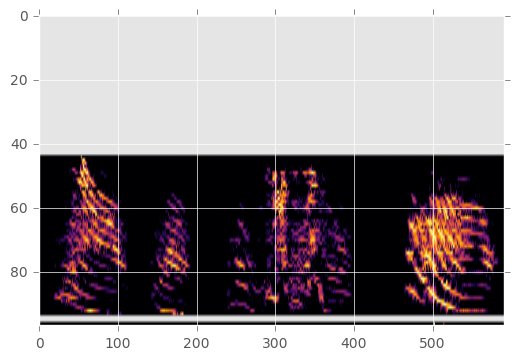

In [7]:
sp = np.array(all_syl_data['spectral'][5])
plt.imshow(normalize(sp)[::-1], cmap='inferno', aspect='auto')

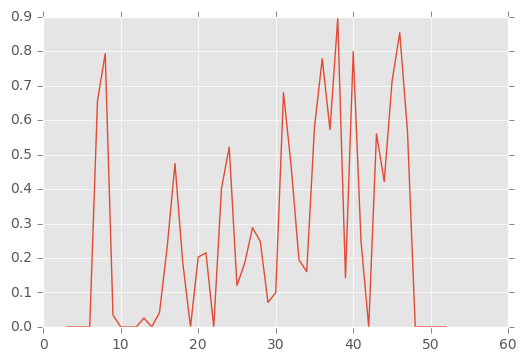

In [14]:
plt.plot(sp[:, 300])

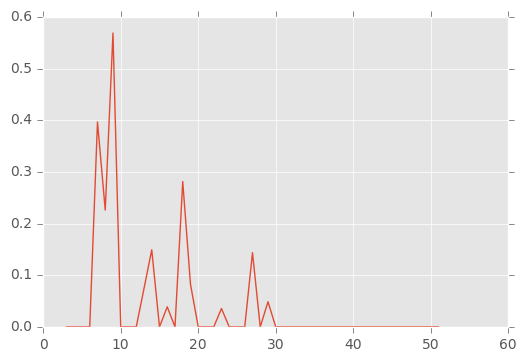

In [9]:
i_bout = 25
sl = np.array(all_syl_data['spectral'][i_bout])
t_i = 50
plt.plot(sl[:,i_bout])

In [37]:
sl.shape

(50, 593)

In [62]:
def slice_compare(x, y):
    a = x/np.max(x)
    b = y/np.max(y)
    #s = np.sum(a+b)
    
    return np.linalg.norm(a-b)/np.sum(a+b)

t_i = 100
one_comp = np.array([slice_compare(sl[:, t_i], sl[:, t_i + i]) for i in np.arange(sl.shape[1] - t_i)])

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


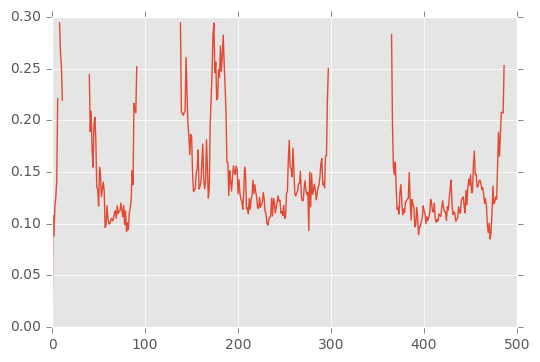

In [64]:
plt.plot(one_comp)

In [66]:
np.nanmin(one_comp)

0.0

In [204]:
os.path.join(fn['folders']['ss'], 'spectral_pandas.pickle')

'/mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-11/spectral_pandas.pickle'

In [180]:
syll_data['spectral'] = syll_data['spectral']/np.amax(syll_data['spectral'].max())

In [192]:
np.max(syll_data['spectral'][50][0])

0.52922646540628193

In [8]:
import scipy
win_s = .005
step_s = .001

n_perseg = int(s_f * win_s)
n_overlap = int(s_f * (win_s - step_s))

def spectrogram(x, s_f, n_perseg = None, n_overlap=None, cut_off=90):
    f, t, s = scipy.signal.spectrogram(x, fs=s_f, window=('tukey', 0.25), 
                         nperseg=n_perseg, 
                         noverlap=n_overlap, 
                         nfft=None, 
                         detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')

    s[s<np.max(s)/np.exp(cut_off/10)]=1
    return f, t, s

f, t, s = spectrogram(all_frames[0].data.flatten(), s_f, n_perseg=n_perseg, n_overlap=n_overlap, cut_off=75)
plt.imshow(np.log(s[::-1]), cmap='inferno', aspect='auto')

NameError: name 'all_frames' is not defined

In [21]:
s=s[f<10000,:]
fr = f[f<10000]

NameError: name 'f' is not defined

In [163]:
s.shape

(50, 593)

In [160]:
f>10000

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

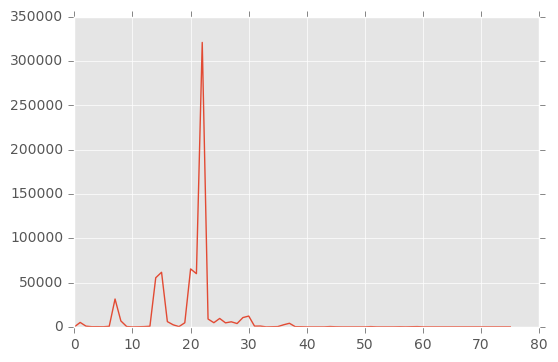

In [102]:
plt.plot(s[:,500])

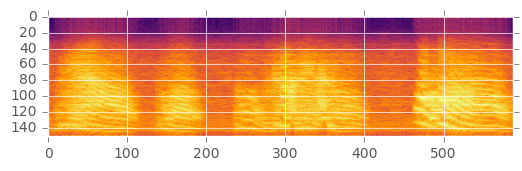

In [52]:
plt.imshow(np.log(s[::-1]), cmap='inferno')